# # IPython Notebook 2: Windy Grid World (With Importance Sampling Ratio)

# Experimental Results


In [190]:
#import the libraries

%matplotlib inline

import gym
import itertools
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import pylab
#import gym_maze

if "../" not in sys.path:
  sys.path.append("../") 

from collections import defaultdict
from lib import plotting

from lib.envs.windy_gridworld import WindyGridworldEnv


matplotlib.style.use('ggplot')


In [191]:

env = WindyGridworldEnv()



In [192]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    We choose an epsilon greedy policy here.
    This is a cool helper function adapted from the WildML blog. 
    """
    
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [193]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [194]:

def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    
    def policy_fn(observation):
        A = np.zeros_like(Q[observation], dtype=float)
        best_action = np.argmax(Q[observation])
        A[best_action] = 1.0
        return A
    return policy_fn

# n-step SARSA

In [195]:
"""
n-step SARSA
"""
def n_sarsa(env, num_episodes, alpha, discount_factor, epsilon,n):
   
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    behaviour_policy = create_greedy_policy(Q)
    
    
    for i_episode in range(num_episodes):
        
        states_list = []
        actions_list = []
        rewards_list = []
        pi_rho = []
        mu_rho = []
        rho_list = []
        
        
        # Reset the environment and pick the first action
        state = env.reset()
        #action_probs = policy(state)
        #action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        
        action_probs = behaviour_policy(state)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        
        initial_state = state
        initial_action = action
        
        
        for t in itertools.count():
            
            next_state, reward, done, _ = env.step(action) #take an action At
                
            states_list.append(next_state) # St+1
            rewards_list.append(reward) # Rt+1
                
            #next_action_probs = policy(next_state)  # Pick the next action
            #next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)
                
                
            next_action_probs = behaviour_policy(next_state)  # Pick the next action
            next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)
            
            next_action_probs_target_policy = policy(next_state)
            
            actions_list.append(next_action) # At+1
        
            pi_rho.append(next_action_probs_target_policy[next_action])
            mu_rho.append(next_action_probs[next_action])
            
            tau = t-n+1
            rho_list.append(float(pi_rho[t]) / mu_rho[t])
           
            if tau == 0:
                rho = 1
            
                
                rho = np.prod(np.array(rho_list[tau:tau+n-1]))
                G = 0
                G = sum(rewards_list[tau:tau+n]) + Q[states_list[tau+n-1]][actions_list[tau+n-1]]
                Q[initial_state][initial_action] = Q[initial_state][initial_action] + alpha * rho * (G - Q[initial_state][initial_action])
            
            elif tau > 0:
                rho = 1
                
                rho = np.prod(np.array(rho_list[tau:tau+n-1]))
                G = 0
                G = sum(rewards_list[tau:tau+n]) + Q[states_list[tau+n-1]][actions_list[tau+n-1]] # tau+n
                    
               
                Q[states_list[tau-1]][actions_list[tau-1]]  = Q[states_list[tau-1]][actions_list[tau-1]] + alpha * rho * (G - Q[states_list[tau-1]][actions_list[tau-1]])
                
                
            
            action = next_action
            state = next_state
                        
            if done:
                break
            
            # Update statistics
        stats.episode_rewards[i_episode] = sum(rewards_list)
        stats.episode_lengths[i_episode] = t
        
          
    
    return Q, stats

In [196]:

#n step sarsa

n_episodes = 3000

alpha = 1
eps = 0.1
gamma = 1
n = 4

alpha = np.zeros([10])
alpha[0] = 0.1


#random_policy = create_random_policy(env.action_space.n)
#behaviour_policy = random_policy

avg_reward_sarsa = np.zeros([10])
for i in range(10):
    
    Q_sarsa, stats_sarsa = n_sarsa(env, n_episodes,alpha[i],gamma,eps,n)
    avg_reward_sarsa[i] = np.sum(stats_sarsa.episode_rewards)/n_episodes
    print "Average reward is", avg_reward_sarsa[i], "for alpha=", alpha[i], "eps=",eps,"discount factor=",gamma, "for n-step SARSA","for n=",n
    if i<9:
        
        alpha[i+1] = alpha[i] + 0.1



Average reward is -19.25 for alpha= 0.1 eps= 0.1 discount factor= 1 for n-step SARSA for n= 4
Average reward is -17.2916666667 for alpha= 0.2 eps= 0.1 discount factor= 1 for n-step SARSA for n= 4
Average reward is -19.431 for alpha= 0.3 eps= 0.1 discount factor= 1 for n-step SARSA for n= 4
Average reward is -18.3366666667 for alpha= 0.4 eps= 0.1 discount factor= 1 for n-step SARSA for n= 4
Average reward is -23.3846666667 for alpha= 0.5 eps= 0.1 discount factor= 1 for n-step SARSA for n= 4
Average reward is -22.5173333333 for alpha= 0.6 eps= 0.1 discount factor= 1 for n-step SARSA for n= 4
Average reward is -16.8426666667 for alpha= 0.7 eps= 0.1 discount factor= 1 for n-step SARSA for n= 4
Average reward is -26.0343333333 for alpha= 0.8 eps= 0.1 discount factor= 1 for n-step SARSA for n= 4
Average reward is -22.653 for alpha= 0.9 eps= 0.1 discount factor= 1 for n-step SARSA for n= 4
Average reward is -23.1336666667 for alpha= 1.0 eps= 0.1 discount factor= 1 for n-step SARSA for n= 4


In [210]:
#one step sarsa

n_episodes = 3000

alpha = 1
eps = 0.1
gamma = 1
n = 1

alpha = np.zeros([10])
alpha[0] = 0.1


#random_policy = create_random_policy(env.action_space.n)
#behaviour_policy = random_policy

avg_reward_sarsa_one = np.zeros([10])
for i in range(10):
    
    Q_sarsa_one, stats_sarsa_one = n_sarsa(env, n_episodes,alpha[i],gamma,eps,n)
    avg_reward_sarsa_one[i] = np.sum(stats_sarsa_one.episode_rewards)/n_episodes
    print "Average reward is", avg_reward_sarsa[i], "for alpha=", alpha[i], "eps=",eps,"discount factor=",gamma, "for n-step SARSA","for n=",n
    if i<9:
        
        alpha[i+1] = alpha[i] + 0.1



Average reward is -19.25 for alpha= 0.1 eps= 0.1 discount factor= 1 for n-step SARSA for n= 1
Average reward is -17.2916666667 for alpha= 0.2 eps= 0.1 discount factor= 1 for n-step SARSA for n= 1
Average reward is -19.431 for alpha= 0.3 eps= 0.1 discount factor= 1 for n-step SARSA for n= 1
Average reward is -18.3366666667 for alpha= 0.4 eps= 0.1 discount factor= 1 for n-step SARSA for n= 1
Average reward is -23.3846666667 for alpha= 0.5 eps= 0.1 discount factor= 1 for n-step SARSA for n= 1
Average reward is -22.5173333333 for alpha= 0.6 eps= 0.1 discount factor= 1 for n-step SARSA for n= 1
Average reward is -16.8426666667 for alpha= 0.7 eps= 0.1 discount factor= 1 for n-step SARSA for n= 1
Average reward is -26.0343333333 for alpha= 0.8 eps= 0.1 discount factor= 1 for n-step SARSA for n= 1
Average reward is -22.653 for alpha= 0.9 eps= 0.1 discount factor= 1 for n-step SARSA for n= 1
Average reward is -23.1336666667 for alpha= 1.0 eps= 0.1 discount factor= 1 for n-step SARSA for n= 1


# n-step expected sarsa

In [197]:
"""
n step expected SARSA
"""
def n_exp_sarsa(env, num_episodes, alpha, discount_factor, epsilon,n):
   
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    behaviour_policy = create_greedy_policy(Q)
    
    for i_episode in range(num_episodes):
        
        states_list = []
        actions_list = []
        rewards_list = []
        pi_rho = []
        mu_rho = []
        rho_list = []
        
        
        # Reset the environment and pick the first action
        state = env.reset()
        #action_probs = policy(state)
        #action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        
        action_probs = behaviour_policy(state)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        
        initial_state = state
        initial_action = action
        
        
        for t in itertools.count():
            
            next_state, reward, done, _ = env.step(action) #take an action At
                
            states_list.append(next_state) # St+1
            rewards_list.append(reward) # Rt+1
                
            next_action_probs = behaviour_policy(next_state)  # Pick the next action
            next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)
            
            next_action_probs_target_policy = policy(next_state)
            
            actions_list.append(next_action) # At+1
        
            pi_rho.append(next_action_probs_target_policy[next_action])
            mu_rho.append(next_action_probs[next_action])
            
            tau = t-n+1
            rho_list.append(float(pi_rho[t]) / mu_rho[t])
           
            
            if tau == 0:
                rho = 1
            
                
                rho = np.prod(np.array(rho_list[tau:tau+n-1]))
                
                G = 0
                G = sum(rewards_list[tau:tau+n]) + np.sum(next_action_probs * Q[states_list[tau+n-1]])
                Q[initial_state][initial_action] = Q[initial_state][initial_action] + alpha * rho* (G - Q[initial_state][initial_action])
            elif tau > 0:
                rho = 1
                
                rho = np.prod(np.array(rho_list[tau:tau+n-1]))
                
                G = 0
                G = sum(rewards_list[tau:tau+n]) + np.sum(next_action_probs * Q[states_list[tau+n-1]])
                    
               
                Q[states_list[tau-1]][actions_list[tau-1]]  = Q[states_list[tau-1]][actions_list[tau-1]] + alpha * rho* (G - Q[states_list[tau-1]][actions_list[tau-1]])
                
           
                
            
            
            action = next_action
            state = next_state
                        
            if done:
                break
            
            # Update statistics
        stats.episode_rewards[i_episode] = sum(rewards_list)
        stats.episode_lengths[i_episode] = t
        
          
    
    return Q, stats

In [198]:

#n expected step sarsa

n_episodes = 3000

eps = 0.1
gamma = 1
n = 4

alpha = np.zeros([10])
alpha[0] = 0.1

avg_reward_exp_sarsa = np.zeros([10])
for i in range(10):
    
    Q_exp_sarsa, stats_exp_sarsa = n_exp_sarsa(env, n_episodes,alpha[i],gamma,eps,n)
    avg_reward_exp_sarsa[i] = np.sum(stats_exp_sarsa.episode_rewards)/n_episodes
    print "Average reward is", avg_reward_exp_sarsa[i], "for alpha=", alpha[i], "eps=",eps,"discount factor=",gamma, "for n-step expected SARSA","for n=",n
    if i<9:
        
        alpha[i+1] = alpha[i] + 0.1



Average reward is -19.25 for alpha= 0.1 eps= 0.1 discount factor= 1 for n-step expected SARSA for n= 4
Average reward is -17.2916666667 for alpha= 0.2 eps= 0.1 discount factor= 1 for n-step expected SARSA for n= 4
Average reward is -19.431 for alpha= 0.3 eps= 0.1 discount factor= 1 for n-step expected SARSA for n= 4
Average reward is -18.3366666667 for alpha= 0.4 eps= 0.1 discount factor= 1 for n-step expected SARSA for n= 4
Average reward is -23.3846666667 for alpha= 0.5 eps= 0.1 discount factor= 1 for n-step expected SARSA for n= 4
Average reward is -22.5173333333 for alpha= 0.6 eps= 0.1 discount factor= 1 for n-step expected SARSA for n= 4
Average reward is -16.8426666667 for alpha= 0.7 eps= 0.1 discount factor= 1 for n-step expected SARSA for n= 4
Average reward is -26.0343333333 for alpha= 0.8 eps= 0.1 discount factor= 1 for n-step expected SARSA for n= 4
Average reward is -22.653 for alpha= 0.9 eps= 0.1 discount factor= 1 for n-step expected SARSA for n= 4
Average reward is -23.1

In [206]:

#one step expected step sarsa

n_episodes = 3000

eps = 0.1
gamma = 1
n = 1

alpha = np.zeros([10])
alpha[0] = 0.1

avg_reward_exp_sarsa_one = np.zeros([10])
for i in range(10):
    
    Q_exp_sarsa_one, stats_exp_sarsa_one = n_exp_sarsa(env, n_episodes,alpha[i],gamma,eps,n)
    avg_reward_exp_sarsa_one[i] = np.sum(stats_exp_sarsa_one.episode_rewards)/n_episodes
    print "Average reward is", avg_reward_exp_sarsa[i], "for alpha=", alpha[i], "eps=",eps,"discount factor=",gamma, "for n-step expected SARSA","for n=",n
    if i<9:
        
        alpha[i+1] = alpha[i] + 0.1



Average reward is -19.25 for alpha= 0.1 eps= 0.1 discount factor= 1 for n-step expected SARSA for n= 1
Average reward is -17.2916666667 for alpha= 0.2 eps= 0.1 discount factor= 1 for n-step expected SARSA for n= 1
Average reward is -19.431 for alpha= 0.3 eps= 0.1 discount factor= 1 for n-step expected SARSA for n= 1
Average reward is -18.3366666667 for alpha= 0.4 eps= 0.1 discount factor= 1 for n-step expected SARSA for n= 1
Average reward is -23.3846666667 for alpha= 0.5 eps= 0.1 discount factor= 1 for n-step expected SARSA for n= 1
Average reward is -22.5173333333 for alpha= 0.6 eps= 0.1 discount factor= 1 for n-step expected SARSA for n= 1
Average reward is -16.8426666667 for alpha= 0.7 eps= 0.1 discount factor= 1 for n-step expected SARSA for n= 1
Average reward is -26.0343333333 for alpha= 0.8 eps= 0.1 discount factor= 1 for n-step expected SARSA for n= 1
Average reward is -22.653 for alpha= 0.9 eps= 0.1 discount factor= 1 for n-step expected SARSA for n= 1
Average reward is -23.1

# n-step tree backup

In [199]:
"""
n step tree backup
"""
def n_step_tree(env, num_episodes, alpha, discount_factor, epsilon,n):
   
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    
    for i_episode in range(num_episodes):
        
        states_list = []
        actions_list = []
        rewards_list = []
        delta_list = []
        pi_values = []
        
        
        # Reset the environment and pick the first action
        state = env.reset()
        action_probs = policy(state)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        
        initial_state = state
        initial_action = action
        
        
        for t in itertools.count():
            
            next_state, reward, done, _ = env.step(action) #take an action At
                
            states_list.append(next_state) # St+1
            rewards_list.append(reward) # Rt+1
            
                
            next_action_probs = policy(next_state)  
            
            
            delta_list.append(reward + discount_factor * np.sum(next_action_probs * Q[next_state]) - Q[state][action]) #delta_t
            
            # Pick the next action At+1
            next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs) 
            
            actions_list.append(next_action) # At+1
        
            pi_values.append(next_action_probs[next_action])
            
            tau = t-n+1
            
            if tau == 0:
                
                E = 1
                G = Q[initial_state][initial_action]
                
                for k in range(n):
                    
                    G = G + E * delta_list[k]
                    E = discount_factor * E * pi_values[k]
                
                Q[initial_state][initial_action] = Q[initial_state][initial_action] + alpha * (G - Q[initial_state][initial_action])
            
            
            elif tau > 0:
                
                E = 1
                G = Q[states_list[tau-1]][actions_list[tau-1]]
                
                for k in range(n):
                    j = k + tau
                    G = G + E * delta_list[j]
                    E = discount_factor * E * pi_values[j]
                
                Q[states_list[tau-1]][actions_list[tau-1]] = Q[states_list[tau-1]][actions_list[tau-1]] + alpha * (G - Q[states_list[tau-1]][actions_list[tau-1]])
            
                
                
            '''
            if tau == 0:
                
                G = 0
                G = sum(rewards_list[tau:tau+n]) + np.sum(next_action_probs * Q[states_list[tau+n-1]])
                Q[initial_state][initial_action] = Q[initial_state][initial_action] + alpha * (G - Q[initial_state][initial_action])
           
            elif tau > 0:
                
                G = 0
                G = sum(rewards_list[tau:tau+n]) + np.sum(next_action_probs * Q[states_list[tau+n-1]])
                    
               
                Q[states_list[tau-1]][actions_list[tau-1]]  = Q[states_list[tau-1]][actions_list[tau-1]] + alpha * (G - Q[states_list[tau-1]][actions_list[tau-1]])
            
            '''
           
            action = next_action
            state = next_state
                        
            if done:
                break
            
            # Update statistics
        stats.episode_rewards[i_episode] = sum(rewards_list)
        stats.episode_lengths[i_episode] = t
        
        
          
    
    return Q, stats

In [200]:
#n-step tree backup

n_episodes = 3000

eps = 0.1
gamma = 1
n = 4

alpha = np.zeros([10])
alpha[0] = 0.1

avg_reward_n_tree = np.zeros([10])
for i in range(10):
    
    Q_n_tree, stats_n_tree = n_step_tree(env, n_episodes,alpha[i],gamma,eps,n)
    avg_reward_n_tree[i] = np.sum(stats_n_tree.episode_rewards)/n_episodes
    print "Average reward is", avg_reward_n_tree[i], "for alpha=", alpha[i], "eps=",eps,"discount factor=",gamma, "for n-step tree backup","for n=",n
    if i<9:
        
        alpha[i+1] = alpha[i] + 0.1



Average reward is -19.6236666667 for alpha= 0.1 eps= 0.1 discount factor= 1 for n-step tree backup for n= 4
Average reward is -18.6286666667 for alpha= 0.2 eps= 0.1 discount factor= 1 for n-step tree backup for n= 4
Average reward is -19.5723333333 for alpha= 0.3 eps= 0.1 discount factor= 1 for n-step tree backup for n= 4
Average reward is -18.2246666667 for alpha= 0.4 eps= 0.1 discount factor= 1 for n-step tree backup for n= 4
Average reward is -18.9606666667 for alpha= 0.5 eps= 0.1 discount factor= 1 for n-step tree backup for n= 4
Average reward is -19.5686666667 for alpha= 0.6 eps= 0.1 discount factor= 1 for n-step tree backup for n= 4
Average reward is -18.5856666667 for alpha= 0.7 eps= 0.1 discount factor= 1 for n-step tree backup for n= 4
Average reward is -22.1046666667 for alpha= 0.8 eps= 0.1 discount factor= 1 for n-step tree backup for n= 4
Average reward is -19.8573333333 for alpha= 0.9 eps= 0.1 discount factor= 1 for n-step tree backup for n= 4
Average reward is -20.914333

# n-step Q(sigma)

In [201]:
"""
n step Q(sigma)
"""

def n_step_q_sigma(env, num_episodes, alpha, discount_factor, epsilon,n):
   
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    behaviour_policy = create_greedy_policy(Q)
    
    
    for i_episode in range(num_episodes):
        
        states_list = []
        actions_list = []
        rewards_list = []
        delta_list = []
        pi_values = []
        sigma_values = []
        pi_rho = []
        mu_rho = []
        rho_list = []
        
        
        # Reset the environment and pick the first action
        state = env.reset()
        #action_probs = policy(state)
        #action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        
        action_probs = behaviour_policy(state)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        
        initial_state = state
        initial_action = action
        
        
        for t in itertools.count():
            
            next_state, reward, done, _ = env.step(action) #take an action At
                
            states_list.append(next_state) # St+1
            rewards_list.append(reward) # Rt+1
            
                
            #next_action_probs = policy(next_state)  
            
            # Pick the next action At+1
            #next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs) 
            
            next_action_probs = behaviour_policy(next_state)  # Pick the next action
            next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)
            
            next_action_probs_target_policy = policy(next_state)
            
            actions_list.append(next_action) # At+1
            
            
            
            
            # Store sigma values fo n=4
            
            if t==0:
                sigma_values.append(1)
            elif t==1:
                sigma_values.append(0)
            elif t%2 ==0 and t!=0:
                sigma_values.append(1)
            else:
                sigma_values.append(0)
                    
                    
            delta_list.append(reward + sigma_values[t]* Q[state][action] + discount_factor * (1 - sigma_values[t]) * np.sum(next_action_probs_target_policy * Q[next_state]) - Q[state][action]) #delta_t

            pi_rho.append(next_action_probs_target_policy[next_action])
            mu_rho.append(next_action_probs[next_action])
            
            rho_list.append(float(pi_rho[t]) / mu_rho[t])
            
            pi_values.append(next_action_probs_target_policy[next_action])
            
            tau = t-n+1
            
            if tau == 0:
                rho = 1
                E = 1
                G = Q[initial_state][initial_action]
                
                for k in range(n):
                    
                    G = G + E * delta_list[k]
                    E = discount_factor * E * ((1-sigma_values[k])*pi_values[k] + sigma_values[k])
                    rho = rho * (1 - sigma_values[k] + sigma_values[k]*rho_list[k])
                
                Q[initial_state][initial_action] = Q[initial_state][initial_action] + alpha * rho * (G - Q[initial_state][initial_action])
            
                if done:
                    break
            
            elif tau > 0:
                rho = 1
                E = 1
                G = Q[states_list[tau-1]][actions_list[tau-1]]
                
                for k in range(n):
                    j = k + tau
                    G = G + E * delta_list[j]
                    E = discount_factor * E * ((1-sigma_values[j])*pi_values[j] + sigma_values[j])
                    rho = rho * (1 - sigma_values[j] + sigma_values[j]*rho_list[j])
                    
                Q[states_list[tau-1]][actions_list[tau-1]] = Q[states_list[tau-1]][actions_list[tau-1]] + alpha * rho * (G - Q[states_list[tau-1]][actions_list[tau-1]])
            
                if done:
                    break
            action = next_action
            state = next_state
                        
            if done:
                break
            
            # Update statistics
        stats.episode_rewards[i_episode] = sum(rewards_list)
        stats.episode_lengths[i_episode] = t
        
          
    
    return Q, stats

In [202]:
#n-step Q(sigma)
"""
n_episodes = 3000

eps = 0.1
gamma = 1
n = 4

alpha = np.zeros([10])
alpha[0] = 0.1

avg_reward_n_sigma = np.zeros([10])
for i in range(10):
    
    Q_q_sigma, stats_q_sigma = n_step_q_sigma(env, n_episodes,alpha[i],gamma,eps,n)
    avg_reward_n_sigma[i] = np.sum(stats_q_sigma.episode_rewards)/n_episodes
    print "Average reward is", avg_reward_n_sigma[i], "for alpha=", alpha[i], "eps=",eps,"discount factor=",gamma, "for n-step q sigma","for n=",n
    if i<9:
        
        alpha[i+1] = alpha[i] + 0.1
"""


'\nn_episodes = 3000\n\neps = 0.1\ngamma = 1\nn = 4\n\nalpha = np.zeros([10])\nalpha[0] = 0.1\n\navg_reward_n_sigma = np.zeros([10])\nfor i in range(10):\n    \n    Q_q_sigma, stats_q_sigma = n_step_q_sigma(env, n_episodes,alpha[i],gamma,eps,n)\n    avg_reward_n_sigma[i] = np.sum(stats_q_sigma.episode_rewards)/n_episodes\n    print "Average reward is", avg_reward_n_sigma[i], "for alpha=", alpha[i], "eps=",eps,"discount factor=",gamma, "for n-step tree backup","for n=",n\n    if i<9:\n        \n        alpha[i+1] = alpha[i] + 0.1\n'

# PLOTS

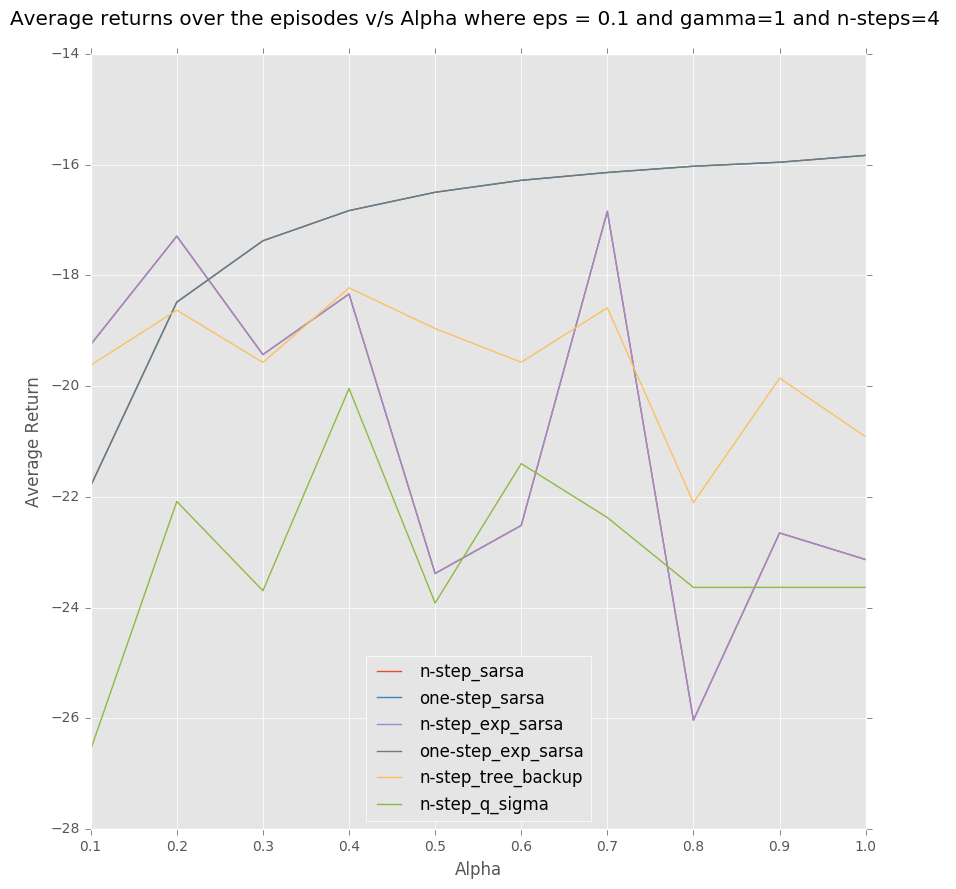

In [212]:
# Plot the above calculated statistics

#avg_reward_n_sigma[8:10] = avg_reward_n_sigma[7]
plt.figure(figsize=(10,10))

plt.title("Average returns over the episodes v/s Alpha where eps = 0.1 and gamma=1 and n-steps=4 \n")
plt.xlabel('Alpha')
plt.ylabel('Average Return')


plt.plot(alpha, avg_reward_sarsa, label='n-step_sarsa')
plt.plot(alpha, avg_reward_sarsa_one, label='one-step_sarsa')
plt.plot(alpha, avg_reward_exp_sarsa, label='n-step_exp_sarsa')
plt.plot(alpha, avg_reward_exp_sarsa_one, label='one-step_exp_sarsa')
plt.plot(alpha, avg_reward_n_tree, label='n-step_tree_backup')
plt.plot(alpha, avg_reward_n_sigma, label='n-step_q_sigma')

plt.legend(loc="best")

plt.show()

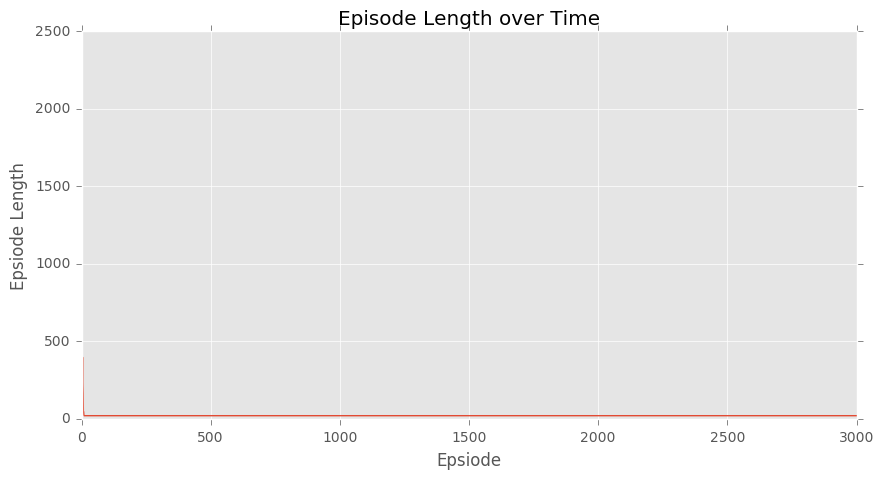

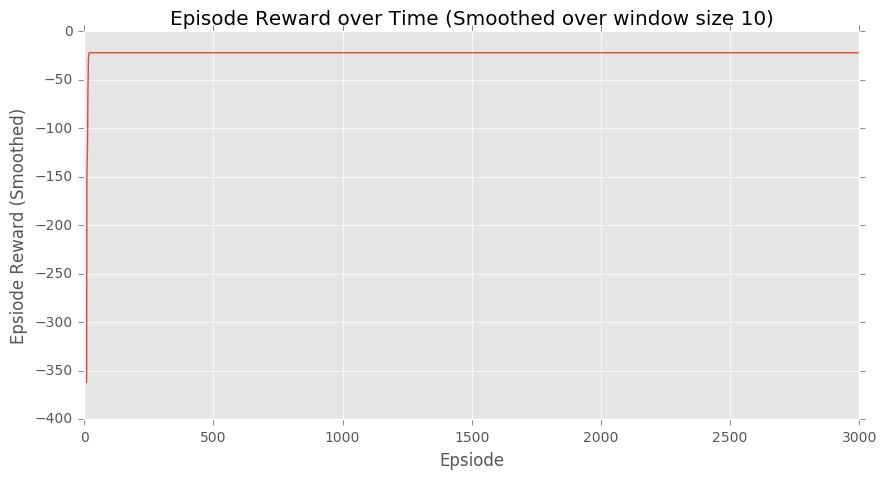

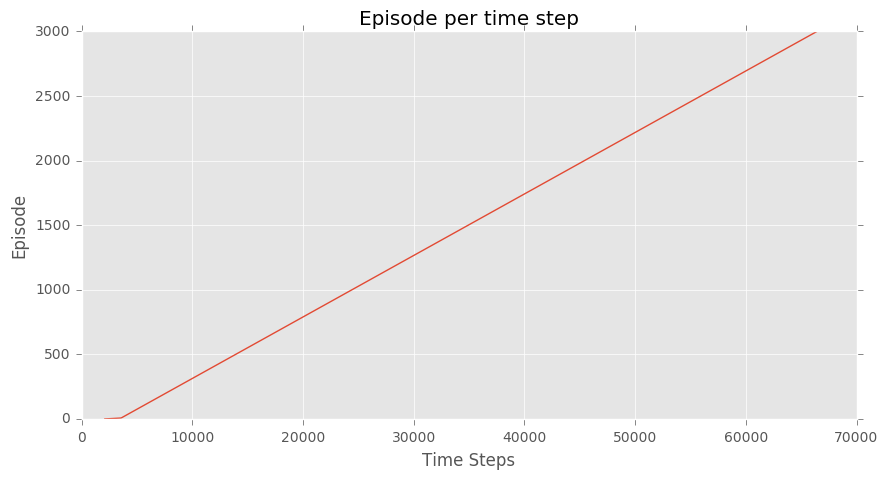

(<matplotlib.figure.Figure at 0x1148cfa90>,
 <matplotlib.figure.Figure at 0x115abfa10>)

In [204]:

"""
Sample Statistics done only for expected sarsa for the sake of clarity:

1. Episode length vs Number of episodes
2. Episode average reward vs Number of episodes
3. Number of episodes vs Time


"""

plotting.plot_episode_stats(stats_exp_sarsa)

# The End